In [1]:
# torch and torchvision imports

import torch, torch.nn as nn, torch.optim as optim
from torchmetrics.classification import MultilabelAUROC
import numpy as np,  matplotlib.pyplot as plt, pandas as pd, pickle
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from ResnetModel import *
from transformer import *
writer = SummaryWriter()
# from google.colab import drive
# drive.mount('/gdrive')
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


2023-12-08 16:38:05.030171: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 16:38:05.082477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 16:38:05.082525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 16:38:05.084012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 16:38:05.094356: I tensorflow/core/platform/cpu_feature_guar

Device: cuda


### Loading and Preparing Data

In [2]:
X_train = torch.from_numpy(np.transpose(np.load('./data/X_train.npz')['arr_0'], axes = (0,2,1))).float()
X_test = torch.from_numpy(np.transpose(np.load('./data/X_val.npz')['arr_0'], axes = (0,2,1))).float()
y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()
y_test = pd.read_csv('./data/Y_val.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()

/tmp/ipykernel_176306/265309155.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()


In [3]:
y_train = torch.from_numpy(y_train).int()
y_test = torch.from_numpy(y_test).int()

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
x = X_train[0:1]
print(x.shape)

torch.Size([1, 12, 1000])


### Creating the Resnet Model

In [5]:
"""Transformer needs X input as (seq_len, batch_size, channels)"""
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
# resnetModel = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).to(device)

# resnetModel(X_train[0:1].to(device))
print(summary(model.to(device), (1,12, 200)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 6]                    --
├─Conv1d: 1-1                            [1, 64, 100]              5,376
├─ReLU: 1-2                              [1, 64, 100]              --
├─BatchNorm1d: 1-3                       [1, 64, 100]              128
├─MaxPool1d: 1-4                         [1, 64, 50]               --
├─Sequential: 1-5                        [1, 256, 50]              --
│    └─Bottleneck: 2-1                   [1, 256, 50]              --
│    │    └─Conv1d: 3-1                  [1, 64, 50]               4,096
│    │    └─ReLU: 3-2                    [1, 64, 50]               --
│    │    └─BatchNorm1d: 3-3             [1, 64, 50]               128
│    │    └─Conv1d: 3-4                  [1, 64, 50]               12,288
│    │    └─ReLU: 3-5                    [1, 64, 50]               --
│    │    └─BatchNorm1d: 3-6             [1, 64, 50]               128
│ 

In [6]:
(4*1024-23.86)/124.66 #Max batch size

32.66597144232312

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [8]:
"""Test AUC metric"""
ml_auroc = MultilabelAUROC(num_labels=3, average="macro", thresholds=None)
# ml_auroc(model(X_train[0:10].to(device)), train_label_mapping[0:10].to(device).int())

### Finding Max Learning rate

In [9]:
criterion = nn.BCELoss()
epochs = 10
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=3).to(device)
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

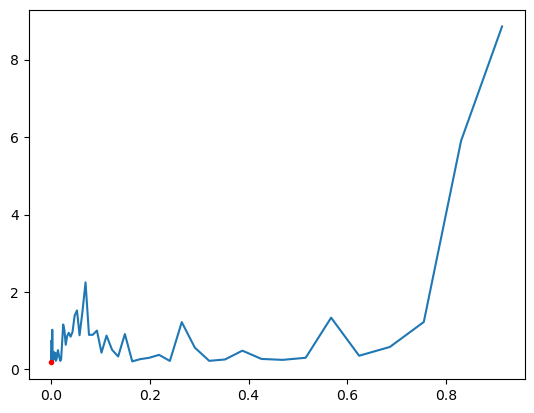

In [10]:
train_loss = []
lrs = []

for i, (signal, labels) in enumerate(train_loader):
    idx = np.random.randint(0, 1000-200)
    signal = (signal[:, :, idx:idx+200]).to(device)
    labels = labels.to(device)
    output = model(signal)
    loss = criterion(output, labels.float())
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    lrs.append(lr)
    lr *= 1.1

    for g in optimizer.param_groups:
        g['lr'] = lr 

    optimizer.step()

    if i > 200 or lr > 1:
        break

lrs = np.array(lrs)
train_loss = np.array(train_loss)

lr_max = lrs[np.where(train_loss == train_loss.min())[0]]

fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()


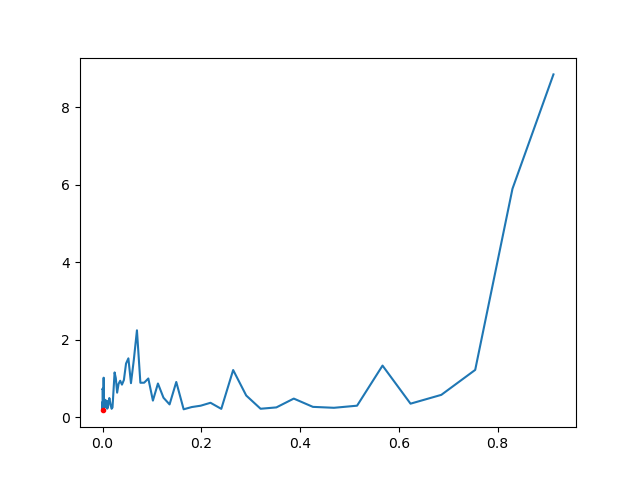

In [11]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

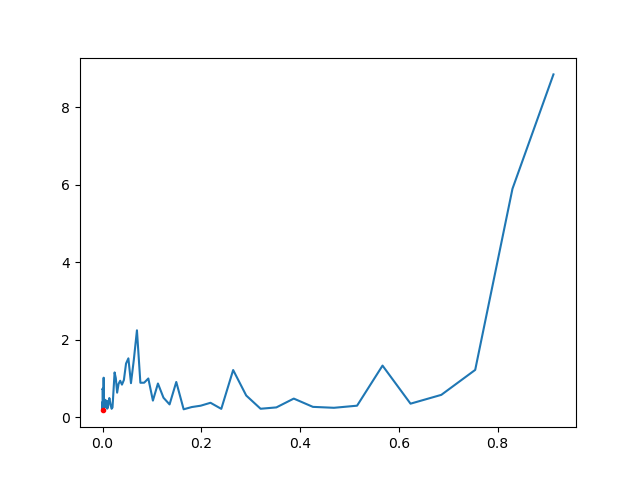

In [12]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [13]:
lr_max

array([0.00020797])

In [14]:
lr_max = 0.0003/10
lr = lr_max
epochs = 100
criterion = nn.BCELoss()
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

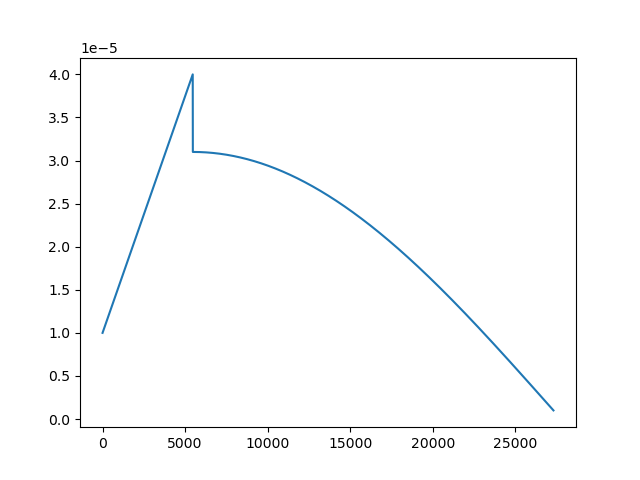

In [15]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-5) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [16]:
lr =lr_max

In [17]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        idx = np.random.randint(0, 1000-200)
        signal_sample = (signal[:, :, idx:idx+200]).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(signal_sample)
        loss = criterion(outputs, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        if t <= T_0:
            lr = 10**(-4) + (t/T_0)*lr_max  
        else: 
            lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

        for g in optimizer.param_groups:
            g['lr'] = lr 
        learning_rates.append(lr)
        train_losses.append(loss.item())
        optimizer.step()
        t+=1
        
        train_AUC = ml_auroc(outputs, labels.int())
        writer.add_scalar("Train_Loss", loss, t)
        writer.add_scalar("Learning rate", lr, t)
        writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%(len(train_loader)//10) == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
           

    # model.eval()
    test_auc = 0
    with torch.no_grad():
        for i, (signal, labels) in enumerate(test_loader):
            idx = np.random.randint(0, 1000-200)
            signal = (signal[:, :, idx:idx+200]).to(device)
            labels = labels.to(device)
            outputs = model(signal)
            test_auc += ml_auroc(outputs, labels.int())
        test_auc /= len(test_loader)
    writer.add_scalar("Test AUC", test_auc, epoch)

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 1/273  |  Train loss: 1.1929  |  Train AUC: 0.3143
Step: 28/273  |  Train loss: 0.3032  |  Train AUC: 0.6518


/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 55/273  |  Train loss: 0.1621  |  Train AUC: 0.6844
Step: 82/273  |  Train loss: 0.2302  |  Train AUC: 0.4718
Step: 109/273  |  Train loss: 0.1701  |  Train AUC: 0.3463
Step: 136/273  |  Train loss: 0.2043  |  Train AUC: 0.4660
Step: 163/273  |  Train loss: 0.2740  |  Train AUC: 0.6251
Step: 190/273  |  Train loss: 0.3761  |  Train AUC: 0.6280
Step: 217/273  |  Train loss: 0.2028  |  Train AUC: 0.5166
Step: 244/273  |  Train loss: 0.4608  |  Train AUC: 0.6416
Step: 271/273  |  Train loss: 0.1420  |  Train AUC: 0.5068
Step: 1/273  |  Train loss: 0.2010  |  Train AUC: 0.6991
Step: 28/273  |  Train loss: 0.1779  |  Train AUC: 0.4462
Step: 55/273  |  Train loss: 0.2158  |  Train AUC: 0.2133
Step: 82/273  |  Train loss: 0.2134  |  Train AUC: 0.3394
Step: 109/273  |  Train loss: 0.2448  |  Train AUC: 0.4076
Step: 136/273  |  Train loss: 0.2914  |  Train AUC: 0.5047
Step: 163/273  |  Train loss: 0.2096  |  Train AUC: 0.4380
Step: 190/273  |  Train loss: 0.1950  |  Train AUC: 0.7199
Step

In [ ]:
signal.shape

In [ ]:
with open('superclassresnetmodel.pickle', 'wb') as f:
    pickle.dump(model, f)